In [147]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
import camb
import matplotlib as mpl
from matplotlib import pyplot as plt
import numpy as np
import mpl_toolkits.axes_grid1 as axgrid
from mpl_toolkits.axes_grid1 import make_axes_locatable
import scipy.optimize
import scipy.stats
plt.rcParams['mathtext.fontset'], plt.rcParams['font.family'] = 'stix', 'STIXGeneral'
plt.rcParams.update({'font.size': 17})

## Creating test/observational data

In [61]:
pars_test = camb.set_params(H0=67.4, 
                            ombh2=0.0224, 
                            omch2=0.120, 
                            redshifts=[0], 
                            kmax=10, 
                            As=2e-9, 
                            ns=0.96, 
                            halofit_version='mead2020_feedback', 
                            HMCode_logT_AGN = 8.4) #Fixing A/eta_baryon at default values
results_test = camb.get_transfer_functions(pars_test)
kh_test, _, pk_test = results_test.get_nonlinear_matter_power_spectrum(hubble_units=True, k_hunit=True)

kh_data = kh_test
pk_data = pk_test[0]

In [62]:
pars_test.NonLinearModel

class: <Halofit>
 Min_kh_nonlinear = 0.005
 halofit_version = mead2020_feedback
 HMCode_A_baryon = 3.13
 HMCode_eta_baryon = 0.603
 HMCode_logT_AGN = 8.4
 

# Testing $\texttt{scipy.optimize.curve_fit}()$ and $\texttt{scipy.optimize.least_squares}()$ on one variable ($\log{T_{AGN}}$)

### Creating cosmology based on Planck2018 (no feedback) for reference

In [63]:
pars_planck_2018 = camb.set_params(H0=67.4, ombh2=0.0224, omch2=0.120,
                                  redshifts=[0], kmax=10, As=2e-9, ns=0.96, 
                                  halofit_version='mead2020_feedback',
                                  HMCode_A_baryon=0, HMCode_eta_baryon=0, HMCode_logT_AGN=-10)
results_planck_2018 = camb.get_transfer_functions(pars_planck_2018)
kh_planck2018, _, pk_planck2018 = results_planck_2018.get_nonlinear_matter_power_spectrum(hubble_units=True, k_hunit=True)

## Using $\texttt{scipy.optimize.curve_fit}()$

In [64]:
def baryon_model_cf(xdata, logT_AGN):
    pars = camb.set_params(H0=67.4, ombh2=0.0224, omch2=0.120, redshifts=[0], kmax=10, As=2e-9, ns=0.96, 
                           halofit_version='mead2020_feedback', 
                           HMCode_logT_AGN = logT_AGN)
    results = camb.get_transfer_functions(pars)
    kh, _ , pk = results.get_nonlinear_matter_power_spectrum(hubble_units=True, k_hunit=True)
    return pk[0]

In [66]:
guess = np.array([9])
popt, pcov = scipy.optimize.curve_fit(baryon_model_cf, kh_data, pk_data, guess) 
popt

array([8.40000018])

In [67]:
popt_cf = popt[0]
popt_cf

8.400000184968237

## Using $\texttt{scipy.optimize.least_squares}()$

In [68]:
def baryon_model_ls(logT_AGN):
    pars = camb.set_params(H0=67.4, 
                            ombh2=0.0224, 
                            omch2=0.120, 
                            redshifts=[0], 
                            kmax=10, 
                            As=2e-9, 
                            ns=0.96, 
                            halofit_version='mead2020_feedback', 
                            HMCode_logT_AGN = logT_AGN)
    results = camb.get_transfer_functions(pars)
    kh, _ , pk = results.get_nonlinear_matter_power_spectrum(hubble_units=True, k_hunit=True)
    return kh, pk[0]

In [69]:
def residuals(baryon, y_data, x_data):
    return y_data - baryon_model_ls(baryon)[1]

In [70]:
guess = np.array([9])

popt_ls = scipy.optimize.least_squares(residuals, guess, args=(pk_data, kh_data)).x

In [71]:
popt_ls = popt_ls[0]
popt_ls

8.40000018211725

## Plotting and Comparing Results

In [72]:
def baryon_model(logT_AGN):
    pars = camb.set_params(H0=67.4, 
                            ombh2=0.0224, 
                            omch2=0.120, 
                            redshifts=[0], 
                            kmax=10, 
                            As=2e-9, 
                            ns=0.96, 
                            halofit_version='mead2020_feedback', 
                            HMCode_logT_AGN = logT_AGN)
    results = camb.get_transfer_functions(pars)
    kh, _ , pk = results.get_nonlinear_matter_power_spectrum(hubble_units=True, k_hunit=True)
    return kh, pk[0]


<Figure size 432x288 with 0 Axes>

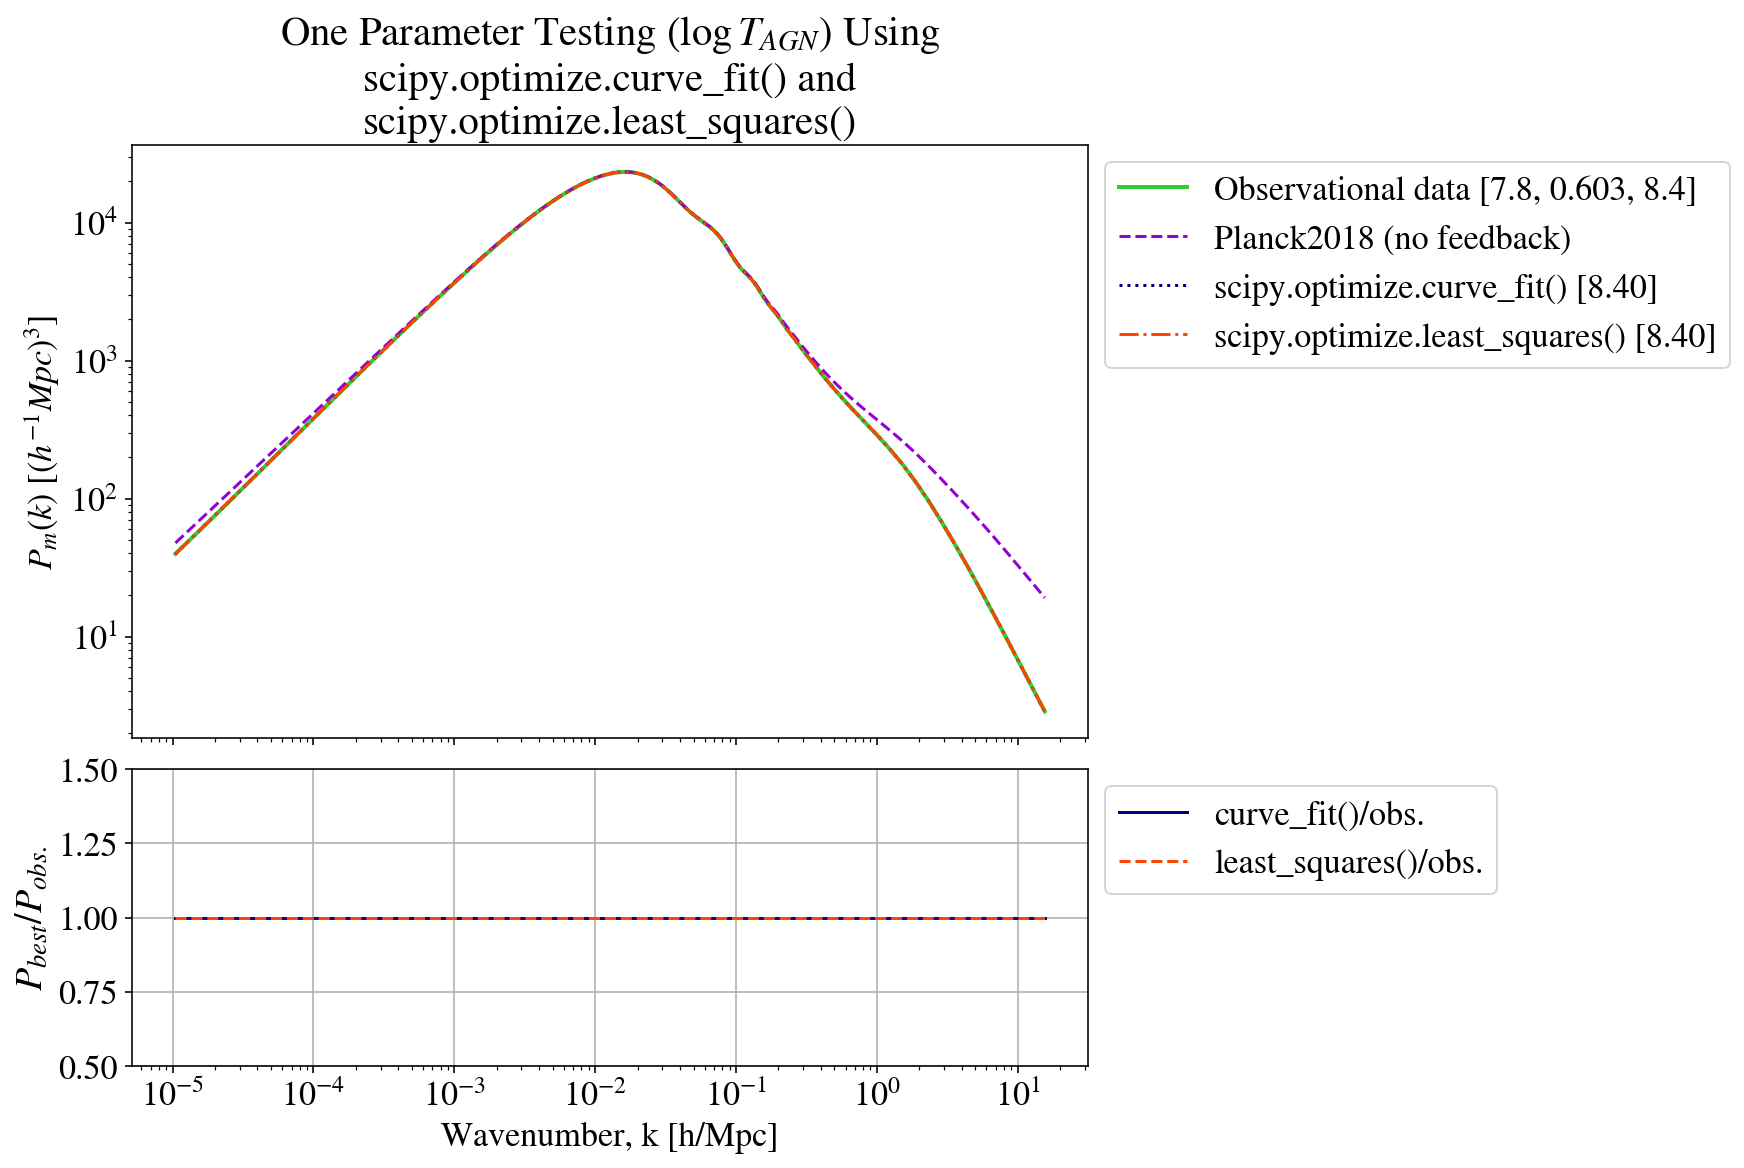

In [91]:
plt.figure()
fig, (ax0, ax1) = plt.subplots(ncols=1, nrows=2, 
                               figsize=(12,8), 
                               constrained_layout=True, 
                               sharex=True, 
                               gridspec_kw={'height_ratios':[3, 1.5]})


ax0.set_title('One Parameter Testing ($\\log{T_{AGN}}$) Using\nscipy.optimize.curve_fit() and\nscipy.optimize.least_squares()')

ax0.loglog(kh_data, pk_data, 'limegreen', label='Observational data [7.8, 0.603, 8.4]', lw=2)
ax0.loglog(kh_planck2018, pk_planck2018[0], 'darkviolet', linestyle='--', label='Planck2018 (no feedback)')
ax0.loglog(kh_data, baryon_model(popt_cf)[1], 'navy', linestyle=':', 
           label='scipy.optimize.curve_fit() [{0:0.2f}]'.format(popt_cf))
ax0.loglog(kh_data, baryon_model(popt_ls)[1], 'orangered', linestyle='-.', 
           label='scipy.optimize.least_squares() [{0:0.2f}]'.format(popt_ls))

#ax0.grid()
ax0.set_ylabel('$P_m(k)$ [($h^{-1}Mpc)^3$]')
ax0.legend(bbox_to_anchor = (1, 1), loc='upper left')


ax1.semilogx(kh_data, baryon_model2(popt_cf)[1]/pk_data, color='navy', linestyle='-', label='curve_fit()/obs.')
ax1.semilogx(kh_data, baryon_model2(popt_ls)[1]/pk_data, color='orangered', linestyle='--', label='least_squares()/obs.')
ax1.legend(bbox_to_anchor = (1, 1), loc='upper left')
# ax1.axhline(1, color='grey', alpha=0.6)
ax1.set_ylabel('$P_{best}/P_{obs.}$', fontsize=19)
ax1.set_xlabel('Wavenumber, k [h/Mpc]')
ax1.set_ylim(0.5,1.5)
ax1.grid()
plt.show()


### Results:

Both $\texttt{scipy.optimize.curve_fit}()$ and $\texttt{scipy.optimize.least_squares}()$ were able to successfully find the $\log{T_{AGN}}$ parameter that matched the input. This is good!

# Brute-Force Chi-Square $\left(\chi^2\right)$ Calculations

### Create chi-square $\chi^2$ function

In [93]:
def chi_square(obs, exp):
    chis = []
    for i in obs:
        num = (i - exp)**2
        chi = np.sum(num/exp)
        chis.append(chi)
    return chis

# obs = observed data = baryon_model()
# exp = experimental data = pk_data

## Testing over wide range

In [94]:
AGN_baryons = np.linspace(7.8*0.95, 7.8*1.30, 30)   # [7.41, 10.14]

In [99]:
def baryon_model(logT_AGN):
    pks = []
    for baryon in logT_AGN:
        pars = camb.set_params(H0=67.4, 
                            ombh2=0.0224, 
                            omch2=0.120, 
                            redshifts=[0], 
                            kmax=10, 
                            As=2e-9, 
                            ns=0.96, 
                            halofit_version='mead2020_feedback', 
                            HMCode_logT_AGN = baryon)
        results = camb.get_transfer_functions(pars)
        kh, _ , pk = results.get_nonlinear_matter_power_spectrum(hubble_units=True, k_hunit=True)
        pks.append(pk[0])
    return pks

In [100]:
pk_varied_baryons = np.array(baryon_model(AGN_baryons))

In [101]:
chis = chi_square(pk_varied_baryons, pk_data)

Minimized chi-square value:  2.0091830798531713 
Corresponding logT_AGN value:  [8.44551724]


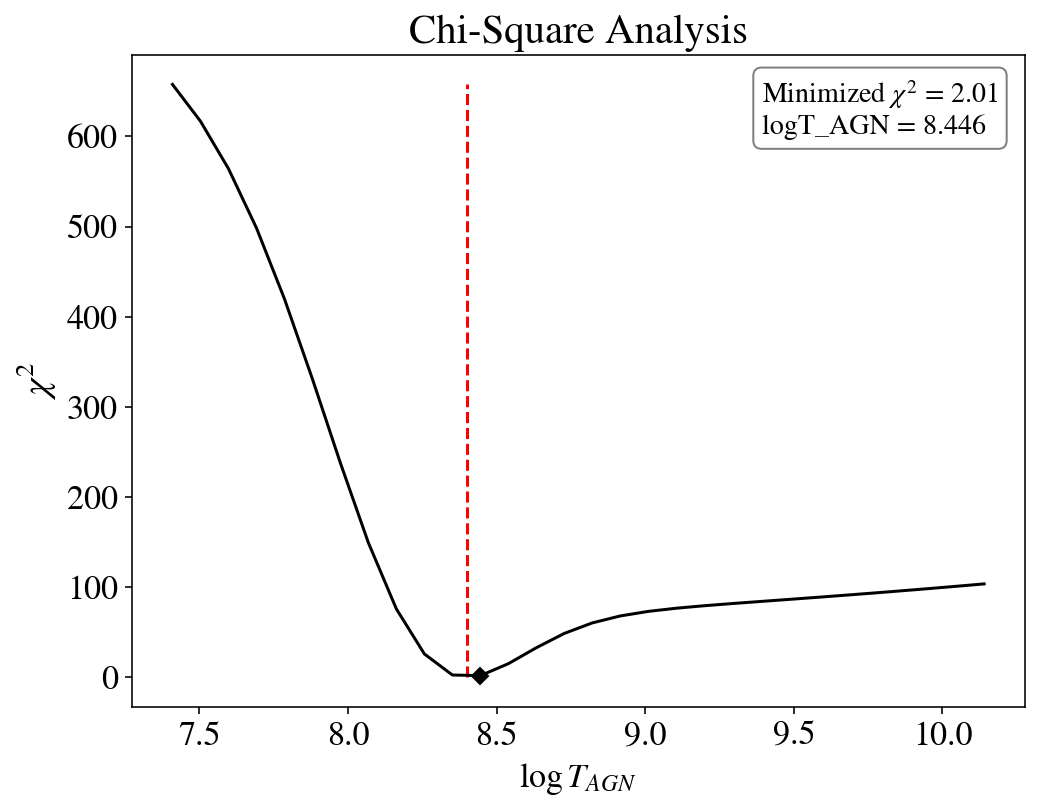

In [141]:
plt.figure(figsize=(8,6))
marker_on = np.argwhere(chis == np.min(chis))[0]
print('Minimized chi-square value: ', np.min(chis), '\nCorresponding logT_AGN value: ', AGN_baryons[marker_on])

plt.title('Chi-Square Analysis')
plt.plot(AGN_baryons, chis, '-kD', markevery=marker_on)
plt.xlabel('$\\log{T_{AGN}}$')
plt.ylabel('$\chi^2$', fontsize=19)
props = dict(boxstyle='round', facecolor='white', alpha=0.5)
plt.text(0.95, 3.55,
        'Minimized $\chi^2$ = {0:.2f}\nlogT_AGN = {1:0.3f}'.format(np.min(chis), AGN_baryons[marker_on][0]),
        transform=ax1.transAxes, 
        fontsize=14,
        verticalalignment='top', 
        bbox=props)
plt.vlines(8.40, 0, np.max(chis), color='red', linestyle='--')

plt.show()

## Testing over a more narrowed range

In [142]:
AGN_baryons = np.linspace(8.0, 9.4, 30)

In [143]:
pk_varied_baryons = np.array(baryon_model(AGN_baryons))

In [144]:
chis = chi_square(pk_varied_baryons, pk_data)

Minimized chi-square value:  0.2061780323540267 
Corresponding logT_AGN value:  [8.3862069]


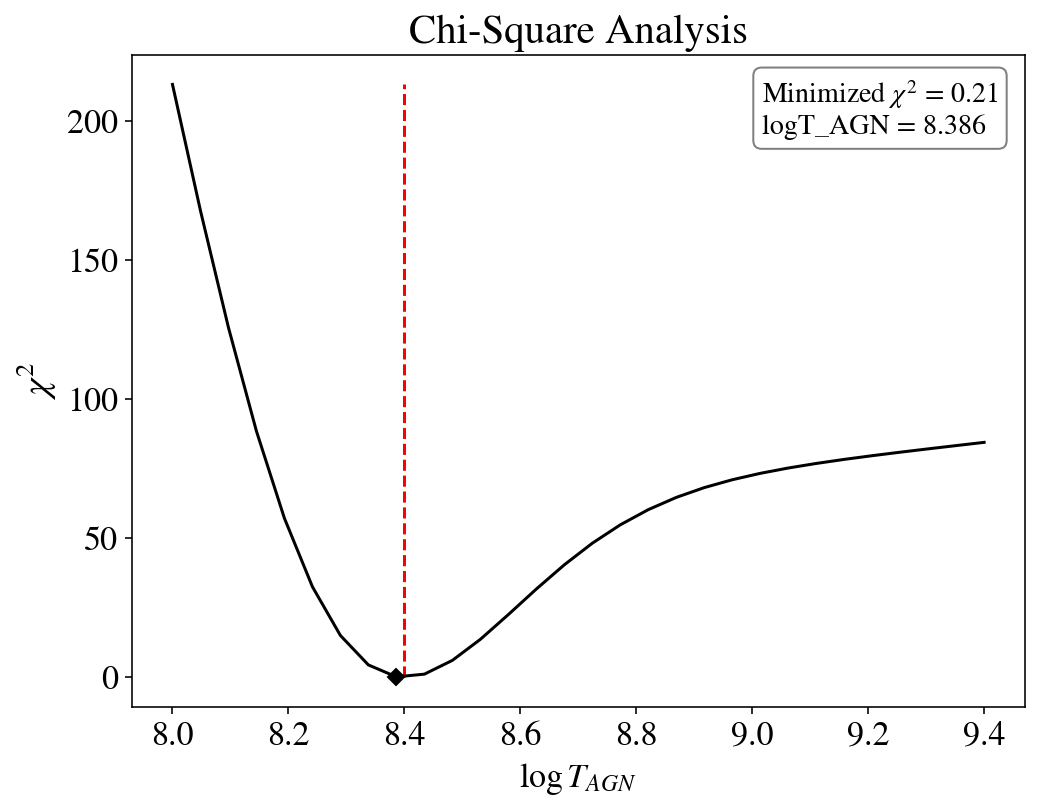

In [145]:
plt.figure(figsize=(8,6))
marker_on = np.argwhere(chis == np.min(chis))[0]
print('Minimized chi-square value: ', np.min(chis), '\nCorresponding logT_AGN value: ', AGN_baryons[marker_on])

plt.title('Chi-Square Analysis')
plt.plot(AGN_baryons, chis, '-kD', markevery=marker_on)
plt.xlabel('$\\log{T_{AGN}}$')
plt.ylabel('$\chi^2$', fontsize=19)
props = dict(boxstyle='round', facecolor='white', alpha=0.5)
plt.text(0.95, 3.55,
        'Minimized $\chi^2$ = {0:.2f}\nlogT_AGN = {1:0.3f}'.format(np.min(chis), AGN_baryons[marker_on][0]),
        transform=ax1.transAxes, 
        fontsize=14,
        verticalalignment='top', 
        bbox=props)
plt.vlines(8.40, 0, np.max(chis), color='red', linestyle='--')

plt.show()